# P2: Project Results (Sigma Squad)

## 1/ Analysis of the final merged data set:

In [19]:
from src.data.transform_data import* 
from src.models.movie_success_model import* 
from src.utils.plot_graphs import*


raw_df = raw_data()
raw_df.to_csv('data/final_merged_data.csv', index=False)

After the loading, merging, and pre-processing of our 3 datasets, we obtained the final dataset (`final_merged_data.csv`) composed of:

|                           | Movie name           | Movie release date | Movie box office revenue | Movie runtime | Movie languages | Movie countries | Movie genres | Movie score | Movie votes | Movie director | Movie star | Movie budget | Movie gross | Movie company | Number of nominations | Nomination winner |
|---------------------------|----------------------|---------------------|--------------------------|---------------|-----------------|-----------------|--------------|-------------|-------------|-----------------|------------|--------------|-------------|---------------|-----------------------|-------------------|
| **Type of values**        | Str                  | Int                | Float                    | Int           | Str             | Str             | Str          | Float       | Int         | Str             | Str        | Float        | Float       | Str           | Int                   | Int               |
| **Example**               | midnight_in_paris	       | 2011              | 151119219.0               | 100.0           | French Language          | United States of America, Spain      | Romantic comedy, Romance Film        | 7.7         | 398000.0      | Woody Allen | Owen Wilson | 17000000.0   | 151653750.0	  | Mediapro	 | 1.0                     | Dianne Wiest	               |
| **Number of rows with info** |  81741               | 74839                 |  8401                       | 61291            | 81741              | 73587              | 79447          | 5605          | 5605          | 5605              | 5605        | 4148           | 5496          | 5596            | 1011                    | 297                |

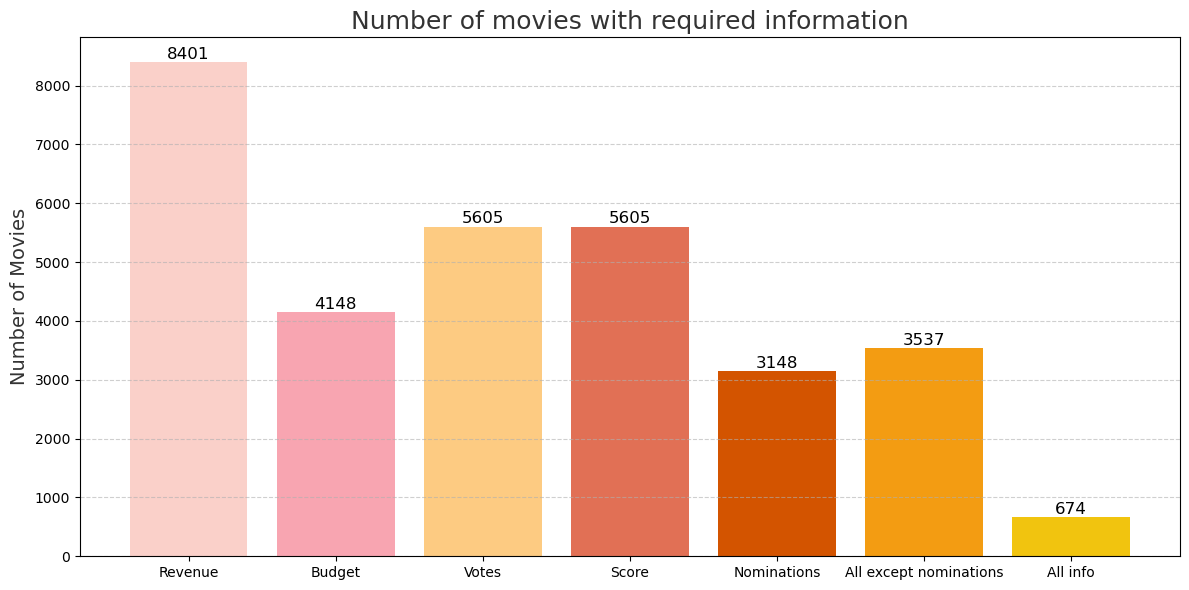

In [20]:
bar_plot_available_data(raw_df)

To establish the success of our index, we are focused on specific criteria such as budget, revenues, ratings, number of nominations, and the profitability. Our goal is to assess whether we have enough reliable data to effectively study these factors. We analyzed the available data and determined that the original CMU Movie dataset contains 8 401 movies, with revenue data as the minimum required for our project. From the additional dataset, we identified 5 119 movies that meet other key criteria, including budget, votes, and score, which represents about 64% of the original dataset. Given this sample size, we are confident that we have sufficient and reliable data to move forward with constructing the success index. The next step will be to normalize and properly weight each criterion to build the success index.

In [21]:
df = clean_data(raw_df)

## 2/ Movie success index:

To create our success index, we evaluated movie success based on four key factors: profitability, revenue, reviews, and Oscar nominations. Both profitability and revenue were scaled using min-max normalization, providing a consistent framework to evaluate and compare success across variables with different ranges. 

After calculating the factors, we combined them into a final index. Profitability, revenue, and review factors are weighted (35%, 35%, and 30%, respectively) and adjusted by the Oscar factor. The resulting index is normalized again to a 0-10 scale, offering a single score representing each movie’s overall success.

Here is a more detailed explanation of the setup of each factor. Note that all functions used can be found in the `src/movie_success_model.py` file.

- **Profitability factor:** this factor measures how much revenue a movie generates relative to its budget. First, the profitability ratio (revenue divided by budget) is calculated. To reduce the impact of outliers, a logarithmic transformation (log) is applied, which compresses large values and accentuates smaller ones. The result is normalized to a 0-10 scale, making comparisons across movies straightforward.

- **Revenue factor:** this factor focuses solely on the movie's box office revenue. A log10 transformation is applied to balance the range of high and low revenues, particularly since box office numbers can vary greatly. After applying the transformation, scores are scaled from 0 to 10 for consistency.

- **Review factor:** this factor is directly takimg from the ImdB ratings of movie which was alreadz on a scale from 0 to 10.

- **Oscar multiplication factor:** this factor amplifies the success index based on Oscar nominations, recognizing industry recognition as a mark of success. The function uses a logarithmic transformation for diminishing returns, giving a smaller increase for each additional nomination, then scales by a multiplier to ensure consistent weighting.



Below are histograms for each factor, showing the final distribution after applying our adjustments.

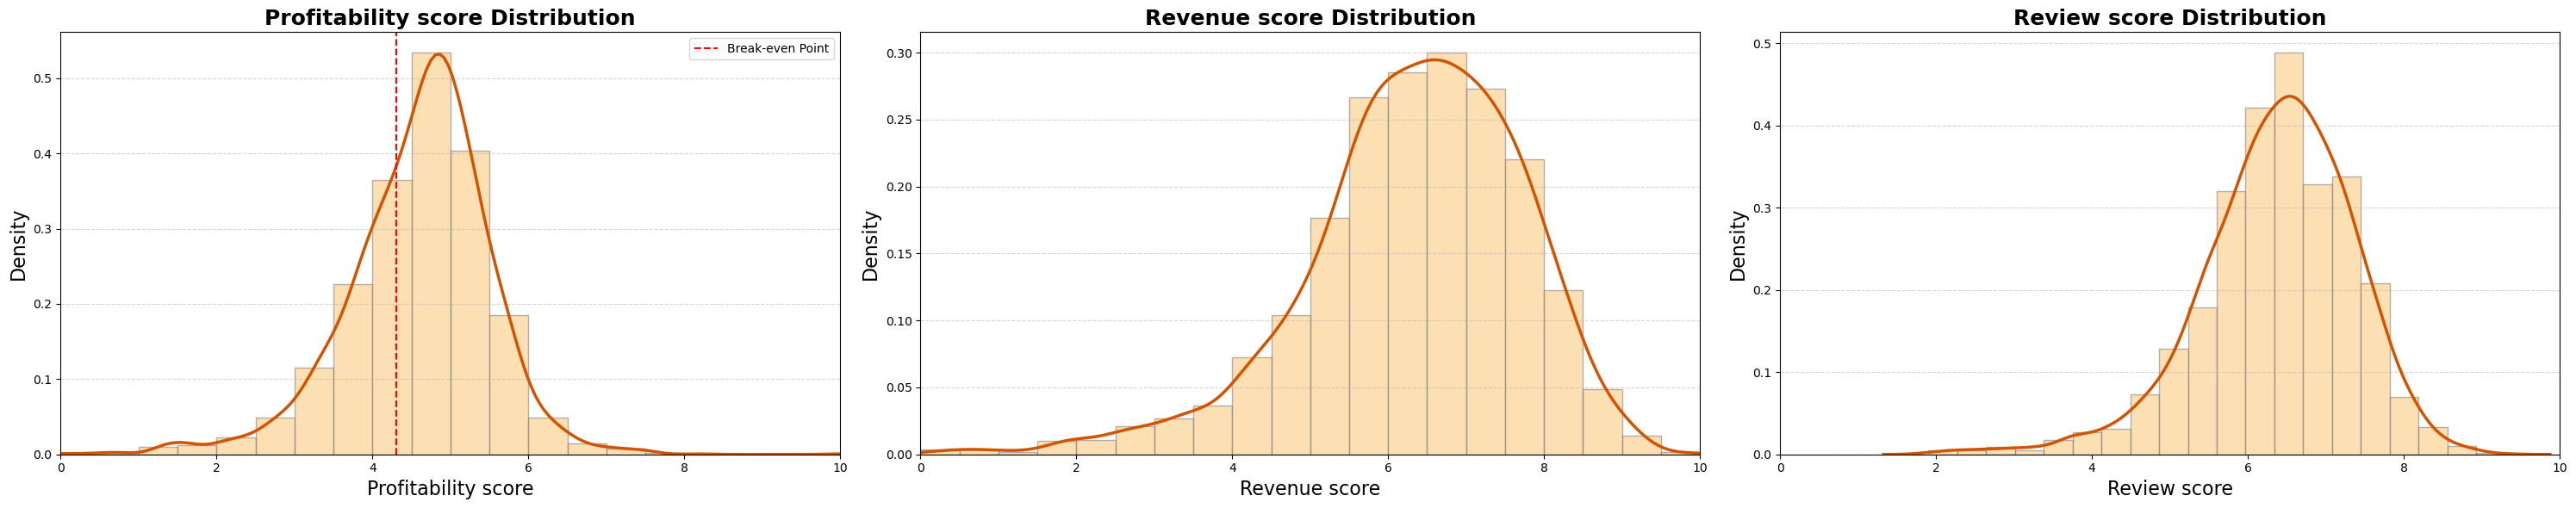

In [22]:
movie_success_index(df)

fig, axes = plt.subplots(1, 3, figsize=(30, 6))  
hist_std_config_ax(df, 'Profitability score', axes[0])
hist_std_config_ax(df, 'Revenue score', axes[1])
hist_std_config_ax(df, 'Review score', axes[2])

plt.tight_layout()
plt.show()
    

### ***Example of ranking based on our movie success index :*** top 5 best and worst movies

In [23]:
top5_best(df)

,Movie name,Movie release date,Movie Success Index,Review score,Revenue score,Profitability score
80920,the_lord_of_the_rings:_the_return_of_the_king,2003,7.916470,8.9,9.257307,5.999965
79973,the_lord_of_the_rings:_the_fellowship_of_the_ring,2001,7.850975,8.8,9.052642,5.835857
65287,forrest_gump,1994,7.844366,8.8,8.846968,6.022649
57552,e.t._the_extra-terrestrial,1982,7.818620,7.8,8.975484,7.262251
23702,avatar,2009,7.734081,7.8,10.000000,5.989874


In [24]:
top5_worst(df)

,Movie name,Movie release date,Movie Success Index,Review score,Revenue score,Profitability score
8416,deadfall,1993,1.034197,4.0,0.264990,0.000000
19093,dangerous_game,1993,1.524680,5.6,0.471943,0.173344
10467,wicked_stepmother,1989,1.735934,4.3,0.973217,1.540833
76763,the_specials,2000,1.770565,5.8,0.000000,1.352018
58128,best_laid_plans,1999,1.780705,6.1,0.603631,0.527457


## 3/ Actor Success Index:

Now that we have established our movie success index we can move on to creating an actor success index. The goal is to be able to quantitatively compare the success of an actor and their career given the success of their movies. The main challenge in doing so is finding a meaningful way to do so. To illustrate, our initial attempts at building the index relied on a mean of scores over an actors career. However, with this method, the most successful actors where side characters that starred in only one or two movies, but that happened to be huge successes. The indey therefore needs to account not only for the absolute success of the movies but also for the amount quality movies and the consistency of success.

To do so we have come up with a multiplier and streak system. For every actor, their movies are sorted by year of release in ascending order. From the score of every movie, a multiplier is generated. If the score is within 25% of the last movie or better, the multiplier is generated proportionaly from the movie score (it is greater than 1, see code for the formula). If the score of the movie happens to be more than 25% worse than the last, the multiplier is transformed to one proportional to the percent difference between both successive movies (and is therefore smaller than 1). This way, successive successful movies grow the multiplier, whilst inconsistencies and drops in quality decrease it.

 The product of all multipliers up to the current one (cumulative multiplier) is applied to the current movie score and the product is added to an array. The array for every movie is summed and a log10 is applied to the sum. The results are then normalized using min-max normalization to obtain a comparable grade out of 10. 

In [25]:
actor_df = actor_data(df)